In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import datetime

import statsmodels.tsa.api as smt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [11]:
pwd

'/Users/deepz/Downloads'

In [12]:
model_df = pd.read_csv('cleaned_data.csv')

In [13]:
def load_data():  
    return pd.read_csv('cleaned_data.csv')  

accident_data = load_data()

In [14]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9820 entries, 0 to 9819
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9820 non-null   int64 
 1   id            9820 non-null   int64 
 2   num_of_rider  9820 non-null   int64 
 3   country       9820 non-null   object
 4   city          9820 non-null   object
 5   employment    9820 non-null   object
 6   transport     9820 non-null   object
 7   accidents     9820 non-null   int64 
 8   losses        9820 non-null   int64 
 9   salary        9820 non-null   int64 
 10  insurance     9820 non-null   object
 11  deliveries    9820 non-null   int64 
 12  date          9820 non-null   object
 13  time          9820 non-null   object
dtypes: int64(7), object(7)
memory usage: 1.0+ MB


In [15]:
accident_data.tail()

,Unnamed: 0,id,num_of_rider,country,city,employment,transport,accidents,losses,salary,insurance,deliveries,date,time
9815,9993,9076,1168,Turkey,Yemeksepeti,freelance rider,Bike,1,155,2096,Y,128,2018-04-01 00:00:00,09:45
9816,9994,9418,3197,Turkey,Yemeksepeti,freelance rider,Bike,5,51,2103,N,122,2018-04-01 00:00:00,23:56
9817,9995,9774,814,Turkey,Yemeksepeti,own rider,Bike,5,49,2503,Y,123,2018-04-01 00:00:00,09:11
9818,9996,9828,466,Turkey,Yemeksepeti,freelance rider,Bike,4,123,2186,N,50,2018-04-01 00:00:00,23:06
9819,9997,9891,971,Turkey,Yemeksepeti,third party rider,Scooter,4,70,2143,N,122,2018-04-01 00:00:00,04:09


In [16]:
def daily_accident(data):
    daily_data = data.copy()
    daily_data.date = accident_data.date.apply(lambda x: str(x)[:-3])
    daily_data = accident_data.groupby('date')['accidents'].sum().reset_index()
    daily_data.date = pd.to_datetime(daily_data.date)
    return daily_data

In [17]:
daily_df = daily_accident(accident_data)
daily_df.head()

,date,accidents
0,2018-04-01,47
1,2018-04-02,81
2,2018-04-03,25
3,2018-04-04,54
4,2018-04-05,62


In [18]:
daily_df.info

<bound method DataFrame.info of           date  accidents
0   2018-04-01         47
1   2018-04-02         81
2   2018-04-03         25
3   2018-04-04         54
4   2018-04-05         62
..         ...        ...
756 2020-04-26         45
757 2020-04-27         48
758 2020-04-28         44
759 2020-04-29         68
760 2020-04-30         67

[761 rows x 2 columns]>

In [19]:
daily_df.shape


(761, 2)

In [20]:
# EDA
# Duration of dataset
def accident_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
accident_duration(accident_data)

760 days
2.0821917808219177 years


In [21]:
# Determining Stationarity
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Accidents')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Accidents')   
    
    ax.set(xlabel = "Date",
           ylabel = "Accidents",
           title = title)
    
    sns.despine()

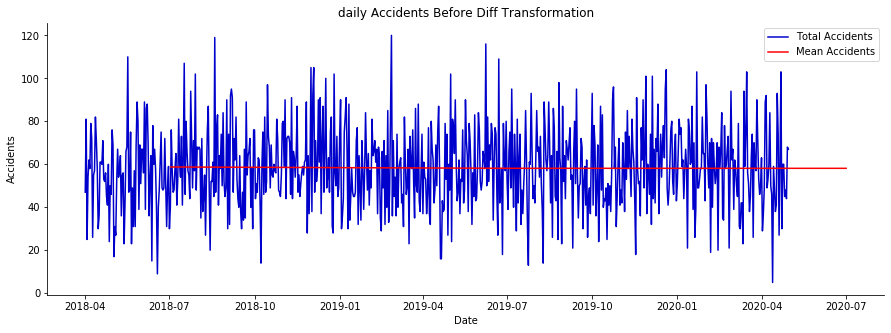

In [22]:
time_plot(daily_df, 'date', 'accidents', 'daily Accidents Before Diff Transformation')

In [23]:
def get_diff(data):
    data['accidents_diff'] = data.accidents.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')
    return data

In [24]:
stationary_df = get_diff(daily_df)

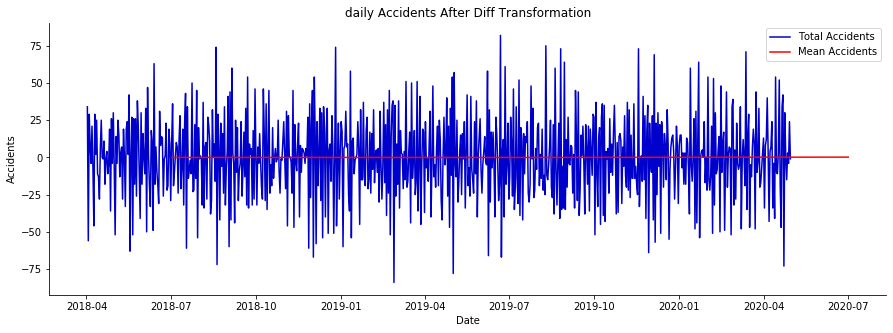

In [25]:
time_plot(stationary_df, 'date', 'accidents_diff', 'daily Accidents After Diff Transformation')

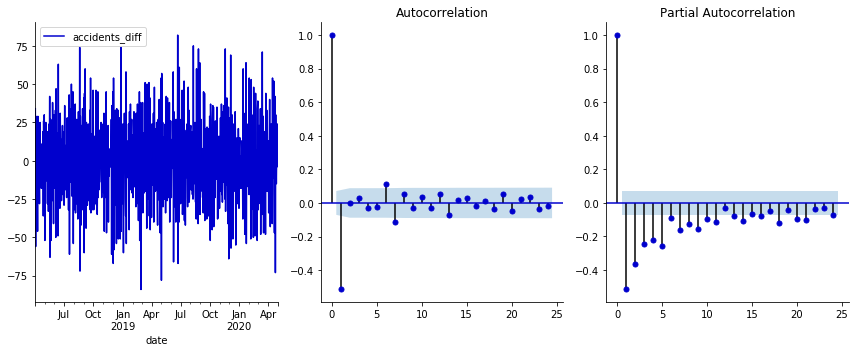

In [26]:
# Observing Lags
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('accidents', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

In [27]:
# Dataset Prep
# Regression Modeling

In [28]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['accidents_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('model_df.csv', index=False)
    
    return supervised_df

In [29]:
model_df = generate_supervised(stationary_df)

In [30]:
model_df

,date,accidents,accidents_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2018-04-14,58,-13.0,-11.0,25.0,2.0,29.0,-46.0,-7.0,21.0,-4.0,8.0,29.0,-56.0,34.0
1,2018-04-15,30,-28.0,-13.0,-11.0,25.0,2.0,29.0,-46.0,-7.0,21.0,-4.0,8.0,29.0,-56.0
2,2018-04-16,36,6.0,-28.0,-13.0,-11.0,25.0,2.0,29.0,-46.0,-7.0,21.0,-4.0,8.0,29.0
3,2018-04-17,61,25.0,6.0,-28.0,-13.0,-11.0,25.0,2.0,29.0,-46.0,-7.0,21.0,-4.0,8.0
4,2018-04-18,61,0.0,25.0,6.0,-28.0,-13.0,-11.0,25.0,2.0,29.0,-46.0,-7.0,21.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,2020-04-26,45,-15.0,0.0,30.0,-73.0,42.0,34.0,-47.0,-19.0,52.0,3.0,-11.0,-10.0,54.0
744,2020-04-27,48,3.0,-15.0,0.0,30.0,-73.0,42.0,34.0,-47.0,-19.0,52.0,3.0,-11.0,-10.0
745,2020-04-28,44,-4.0,3.0,-15.0,0.0,30.0,-73.0,42.0,34.0,-47.0,-19.0,52.0,3.0,-11.0
746,2020-04-29,68,24.0,-4.0,3.0,-15.0,0.0,30.0,-73.0,42.0,34.0,-47.0,-19.0,52.0,3.0


In [31]:
# ARIMA Modeling - IGNORE as not pursued

In [32]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('accidents', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('arima_df.csv')
    
    return dt_data

In [33]:
datetime_df = generate_arima_data(stationary_df)

In [34]:
datetime_df

,accidents_diff
date,
2018-04-02,34.0
2018-04-03,-56.0
2018-04-04,29.0
2018-04-05,8.0
2018-04-06,-4.0
...,...
2020-04-26,-15.0
2020-04-27,3.0
2020-04-28,-4.0
